In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention,
    Softmax
)
from tensorflow.keras.initializers import TruncatedNormal

In [ ]:
class PatchPartition(Layer):
    def __init__(self, window_size=4, channles=3):
        super(PatchPartition, self).__init__()
        self.window_size = window_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
!curl -s -o flower.jpeg https://images.unsplash.com/photo-1604085572504-a392ddf0d86a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=224&q=224

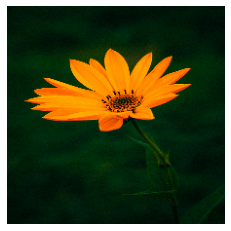

In [ ]:
image = plt.imread('flower.jpeg')
image = tf.image.resize(tf.convert_to_tensor(image), size=(224, 224))
plt.imshow(image.numpy().astype("uint8"))
plt.axis("off");

In [ ]:
batch = tf.expand_dims(image, axis=0)
patches = PatchPartition()(batch)
patches.shape

TensorShape([1, 3136, 48])

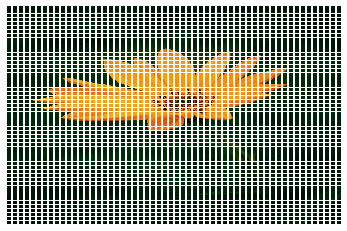

In [ ]:
n = int(np.sqrt(patches.shape[1]))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (4, 4, 3))
    ax.imshow(patch_img.numpy().astype("uint8"))
    ax.axis("off")

In [ ]:
class LinearEmbedding(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(LinearEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = Dense(projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [ ]:
embeddings = LinearEmbedding(3136, 96)(patches)
embeddings.shape

TensorShape([1, 3136, 96])

In [ ]:
class PatchMerging(Layer):
    def __init__(self, input_resolution, channels):
        super(PatchMerging, self).__init__()
        self.input_resolution = input_resolution
        self.channels = channels
        self.linear_trans = Dense(2 * channels, use_bias=False)

    def call(self, x):
        height, width = self.input_resolution
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [ ]:
channels = 96
num_patch_x = 224 // 4
num_patch_y = 224 // 4
out_patches = PatchMerging((num_patch_x, num_patch_y), channels)(patches)
print(f'Input shape (B,   H * W,  C) = {patches.shape}')
print(f'Ouput shape (B, H/2*W/2, 4C) = {out_patches.shape}')

Input shape (B,   H * W,  C) = (1, 3136, 48)
Ouput shape (B, H/2*W/2, 4C) = (1, 784, 192)


In [ ]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

In [ ]:
mlp = MLP(768 * 2, 768)
y = mlp(tf.zeros((1, 197, 768)))
y.shape

TensorShape([1, 197, 768])

In [ ]:
class WindowAttention(Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        initializer = TruncatedNormal(mean=0., stddev=.02)
        # position table shape is: (2*Wh-1 * 2*Ww-1, nH)
        table_shape = ((2*self.window_size[0]-1) * (2*self.window_size[1]-1), num_heads)
        self.relative_position_bias_table = tf.Variable(initializer(shape=table_shape))

        # get pair-wise relative position index for each token inside the window
        coords_h = tf.range(self.window_size[0])
        coords_w = tf.range(self.window_size[1])
        coords = tf.stack(tf.meshgrid(coords_h, coords_w))  # 2, Wh, Ww
        coords_flatten = tf.reshape(coords, [2, -1])  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = tf.transpose(relative_coords, perm=[1,2,0]) # Wh*Ww, Wh*Ww, 2
        relative_coords = relative_coords + [self.window_size[0] - 1, self.window_size[1] - 1]  # shift to start from 0
        relative_coords = relative_coords * [2*self.window_size[1] - 1, 1]
        self.relative_position_index = tf.math.reduce_sum(relative_coords,-1)  # Wh*Ww, Wh*Ww

        self.qkv = Dense(dim * 3, use_bias=qkv_bias, kernel_initializer=initializer)
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, kernel_initializer=initializer)
        self.proj_drop = Dropout(proj_drop)
        self.softmax = Softmax(axis=-1)

    def call(self, x, mask=None):
        _, L, N, C = x.shape
        qkv = tf.transpose(tf.reshape(self.qkv(x), [-1, N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4]) # [3, B_, num_head, Ww*Wh, C//num_head]
        q, k, v = tf.unstack(qkv)  # make torchscript happy (cannot use tensor as tuple)
        q = q * self.scale
        attn = tf.einsum('...ij,...kj->...ik', q, k)
        relative_position_bias = tf.reshape(tf.gather(self.relative_position_bias_table, tf.reshape(self.relative_position_index, [-1])),
            [self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = tf.transpose(relative_position_bias, perm=[2, 0, 1])  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias

        if mask is not None:
            nW = mask.shape[0] # every window has different mask [nW, N, N]
            attn = tf.reshape(attn, [-1 // nW, nW, self.num_heads, N, N]) + mask[:, None, :, :] # add mask: make each component -inf or just leave it
            attn = tf.reshape(attn, [-1, self.num_heads, N, N])
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = tf.reshape(tf.transpose(attn @ v, perm=[0, 2, 1, 3]), [-1, L, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [ ]:
attn = WindowAttention(96, window_size=(4, 4), num_heads=8, qkv_bias=True, qk_scale=None, attn_drop=0.0, proj_drop=0.0)
y = attn(tf.zeros((1, 196, 16, 96)))
y.shape

TensorShape([1, 196, 16, 96])

In [ ]:
def window_partition(x, window_size):
    _, H, W, C = x.shape
    num_patch_y = H // window_size
    num_patch_x = W // window_size
    x = tf.reshape(x, [-1, num_patch_y, window_size, num_patch_x, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, [-1, num_patch_x * num_patch_y, window_size, window_size, C])
    return windows

In [ ]:
windows = window_partition(batch, 4)
print(f'Input shape (B,   H,  W,  C) = {batch.shape}')
print(f'Ouput shape (num_windows*B, window_size, window_size, C) = {windows.shape}')

Input shape (B,   H,  W,  C) = (1, 224, 224, 3)
Ouput shape (num_windows*B, window_size, window_size, C) = (1, 3136, 4, 4, 3)


In [ ]:
def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    B = int(windows.shape[1] / (H * W / window_size / window_size))
    x = tf.reshape(windows, [B, H // window_size, W // window_size, window_size, window_size, C])
    x = tf.reshape(tf.transpose(x, perm=[0, 1, 3, 2, 4, 5]), [-1, H, W, C])
    return x

In [ ]:
y = window_reverse(windows, 4, 224, 224)
print(f'Input shape (B, num_windows*B, window_size, window_size, C) = {windows.shape}')
print(f'Ouput shape (B,   H,  W,  C) = {y.shape}')

Input shape (B, num_windows*B, window_size, window_size, C) = (1, 3136, 4, 4, 3)
Ouput shape (B,   H,  W,  C) = (1, 224, 224, 3)


In [ ]:
class DropPath(Layer):
    def __init__(self, prob):
        super().__init__()
        self.drop_prob = prob

    def call(self, x, training=None):
        if self.drop_prob == 0. or not training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = tf.random.uniform(shape=shape)
        random_tensor = tf.where(random_tensor < keep_prob, 1, 0)
        output = x / keep_prob * random_tensor
        return output

In [ ]:
drop = DropPath(0.2)
y = drop(tf.zeros((1, 197, 768)))
y.shape

TensorShape([1, 197, 768])

In [ ]:
class SwinTransformerBlock(Layer):

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else tf.identity
        self.norm2 = LayerNormalization(epsilon=1e-5)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(mlp_hidden_dim, dim, dropout_rate=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = np.zeros([1, H, W, 1])  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            img_mask = tf.constant(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = tf.reshape(mask_windows, [-1, self.window_size * self.window_size])
            attn_mask = mask_windows[:, None, :] - mask_windows[:, :, None]
            self.attn_mask = tf.where(attn_mask==0, -100., 0.)
        else:
            self.attn_mask = None

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, [-1, H, W, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = tf.reshape(x_windows, [-1, x_windows.shape[1], self.window_size * self.window_size, C])  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = tf.reshape(attn_windows, [-1, x_windows.shape[1], self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=(1, 2))
        else:
            x = shifted_x
        x = tf.reshape(x, [-1, H * W, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


In [ ]:
block = SwinTransformerBlock(96, (56, 56), 8, window_size=4)
y = block(embeddings)
y.shape

TensorShape([1, 3136, 96])

In [ ]:
def create_SwinTransformer(num_classes, input_shape=(224, 224, 3), window_size=4, embed_dim=96, num_heads=8):
    num_patch_x = input_shape[0] // window_size
    num_patch_y = input_shape[1] // window_size
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchPartition(window_size)(inputs)
    patches_embed = LinearEmbedding(num_patch_x * num_patch_y, embed_dim)(patches)
    # first Swin Transformer block
    out_stage_1 = SwinTransformerBlock(
        dim=embed_dim,
        input_resolution=(num_patch_x, num_patch_y),
        num_heads=num_heads,
        window_size=window_size,
        shift_size=0
    )(patches_embed)
    # second Swin Transformer block
    out_stage_1 = SwinTransformerBlock(
        dim=embed_dim,
        input_resolution=(num_patch_x, num_patch_y),
        num_heads=num_heads,
        window_size=window_size,
        shift_size=1
    )(out_stage_1)
    # patch merging
    representation = PatchMerging((num_patch_x, num_patch_y), channels=embed_dim)(out_stage_1)
    # pooling
    representation = GlobalAveragePooling1D()(representation)
    # logits
    output = Dense(num_classes, activation="softmax")(representation)
    # Create model
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
model = create_SwinTransformer(2)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 patch_partition_21 (PatchPa  (None, None, 48)         0         
 rtition)                                                        
                                                                 
 linear_embedding_22 (Linear  (None, 3136, 96)         305760    
 Embedding)                                                      
                                                                 
 swin_transformer_block_65 (  (None, 3136, 96)         112232    
 SwinTransformerBlock)                                           
                                                                 
 swin_transformer_block_66 (  (None, 3136, 96)         112232    
 SwinTransformerBlock)                                     